In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [14]:
def current_IVs(currency):
    params = {
    "currency": currency,
    "kind": "option"
    }
    request = requests.get("https://www.deribit.com/api/v2/public/get_book_summary_by_currency", params=params)

    df = pd.DataFrame(request.json()["result"]).set_index("instrument_name")
    df["type"] = np.where(df.index.str[-1] == "C", "Call", "Put")
    df["strike"] = df.index.str.split('-').str[2].astype(int)
    df["expiration_date"] = pd.to_datetime(df.index.str.split('-').str[1], format="%d%b%y") + pd.Timedelta(8, 'h')

    df = df[["mark_iv", "type", "expiration_date", "strike"]]
    return df

In [15]:
IVs = current_IVs("BTC")

# Fetch current BTC index price
index_request = requests.get("https://www.deribit.com/api/v2/public/get_index_price", params={"index_name": "btc_usd"})
BTC_price = index_request.json()["result"]["index_price"]
print(f"Current BTC Price: ${BTC_price:,.2f}")

Current BTC Price: $86,920.07


In [16]:
nearest_expiry = min(IVs["expiration_date"])
nearest_expiry_IVs = IVs[IVs["expiration_date"] == nearest_expiry].copy()

# Filter for OTM: Puts < Price, Calls >= Price
otm_puts = nearest_expiry_IVs[(nearest_expiry_IVs["type"] == "Put") & (nearest_expiry_IVs["strike"] < BTC_price)]
otm_calls = nearest_expiry_IVs[(nearest_expiry_IVs["type"] == "Call") & (nearest_expiry_IVs["strike"] >= BTC_price)]
otm_smile = pd.concat([otm_puts, otm_calls]).sort_values("strike")

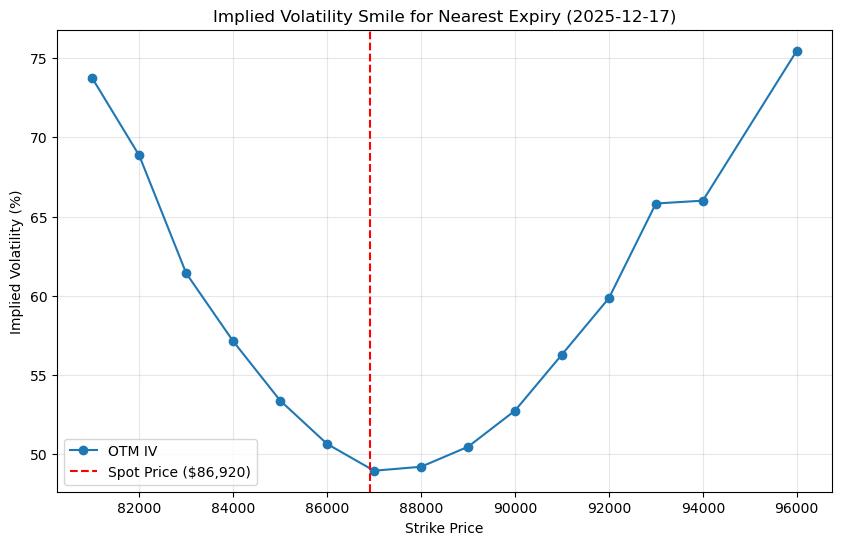

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(otm_smile["strike"], otm_smile["mark_iv"], marker='o', label="OTM IV")
plt.axvline(BTC_price, color='r', linestyle='--', label=f"Spot Price (${BTC_price:,.0f})")
plt.title(f"Implied Volatility Smile for Nearest Expiry ({nearest_expiry.strftime('%Y-%m-%d')})")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
expirations = sorted(IVs["expiration_date"].unique())

ATM_IVs = []
for expiration in expirations:
    cur_expiry_IVs = IVs[IVs["expiration_date"] == expiration]

    # Find strike closest to spot
    closest_strike = cur_expiry_IVs.loc[
        (cur_expiry_IVs["strike"] - BTC_price).abs().idxmin(), "strike"
    ]

    # Average IV of Call and Put at this strike (Straddle IV)
    ivs_at_strike = cur_expiry_IVs[cur_expiry_IVs["strike"] == closest_strike]["mark_iv"]
    ATM_IVs.append(ivs_at_strike.mean())

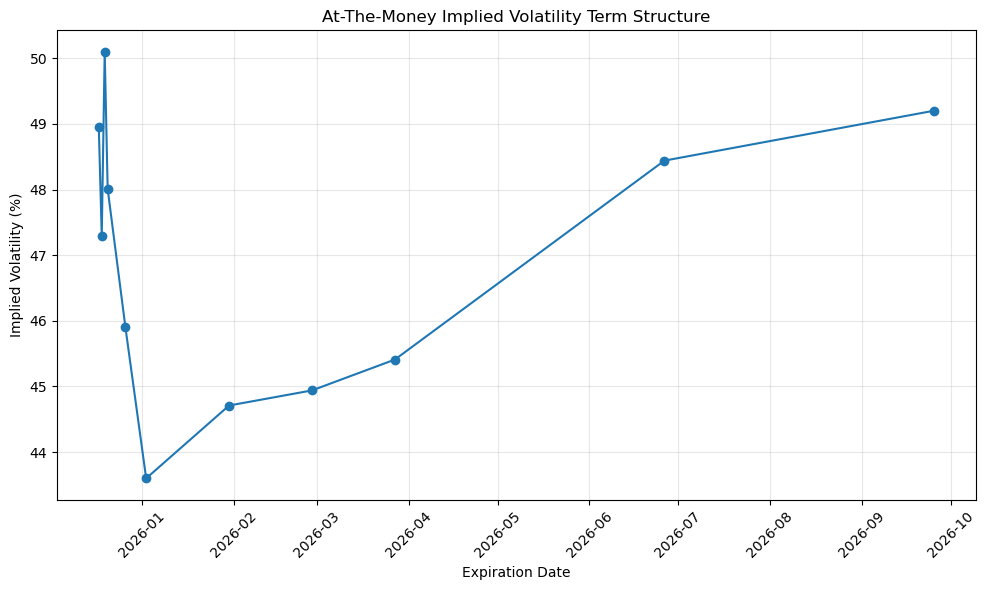

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(expirations, ATM_IVs, marker='o', linestyle='-')
plt.title('At-The-Money Implied Volatility Term Structure') 
plt.xlabel('Expiration Date')
plt.ylabel('Implied Volatility (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()